***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* [6. Deconvolution in Imaging](6_0_introduction.ipynb)  
    * Previous: [6.3 Residuals and Image Quality](6_3_residuals_and_iqa.ipynb)  
    * Next: [6.x Further Reading and References](6_x_further_reading_and_references.ipynb)

***

In [15]:
import matplotlib
from scipy import optimize
import astropy.io.fits

matplotlib.rcParams.update({'font.size': 18})
matplotlib.rcParams.update({'figure.figsize': [12,8]} )

In [16]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

## 6.5 源搜索 Source Finding

在射电天文领域，“源搜索”指的是从数据中获得射电源的属性（如流量密度和形态）的过程。本节我们只涉及图像域的源搜索。


In radio astronomy, *source finding* is the process through which the attributes of radio sources -- such as flux density and morphorlogy -- are measured from data. In this section we will only cover source finding in the image plane.

源搜索技术通常包括四个步骤：1）噪声计算或背景估计；2）根据第一步所估计的噪声设置域值；3）在图像中找出邻近像素相似的区域，即图像处理中的*blob detection*；4）用一个函数（通常是一个2D高斯）来对这些blob进行描述。

Source finding techniques usually involve four steps, i) charecterizing the noise (or background estimation), ii) thresholding the data based on knowledge of the noise, iii) finding regions in the thresholded image with "similar" neighbouring pixels (this is that same as *blob detection* in image processing), and iv) parameterizing these 'blobs' through a function (usually a 2D Gaussian). The source attributes are then estimated from the parameterization of the blobs.

### 6.5.1 噪声特征 Noise Charecterization

如上所述，我们所要处理的射电数据是带噪声的。为便于描述，我们需要对噪声的特性进行一些假设，我们假定噪声是一些斯托克斯过程的产物，因此能用一个正态分布进行描述。

As mentioned before, the radio data we process with source finders is noisy. To charecterize this noise we need to make a few assumptions about its nature, namely we assume that the niose results from some stochastic process and that it can be described by a normal distribution

$$ G(x \, | \, \mu,\sigma^2) = \frac{1}{\sigma \sqrt{2\pi}}\text{exp}\left( \frac{-(x-\mu)^2}{2\sigma^2}\right) $$ 
这里，$\mu$是变量$x$的均值（或期望值），$\sigma^2$是方差，$\sigma$是标准差。因此，噪声可以通过均值和标准差两个参数进行描述。下面是MeerKAT模拟的一张噪声图像和像素直方图（log 空间）。

where, $\mu$ is the mean (or expected value) of the variable $x$, and $\sigma^2$ is the variance of the distribution; $\sigma$ is the standard deviation. Hence, the noise can be parameterized through the mean and the standard deviation. Let us illustrate this with an example. Bellow is a noise image from a MeerKAT simulation, along with a histogram of of the pixels (in log space).

-0.0010957235 0.0010606385 1.947024e-07 0.0002110248 2762


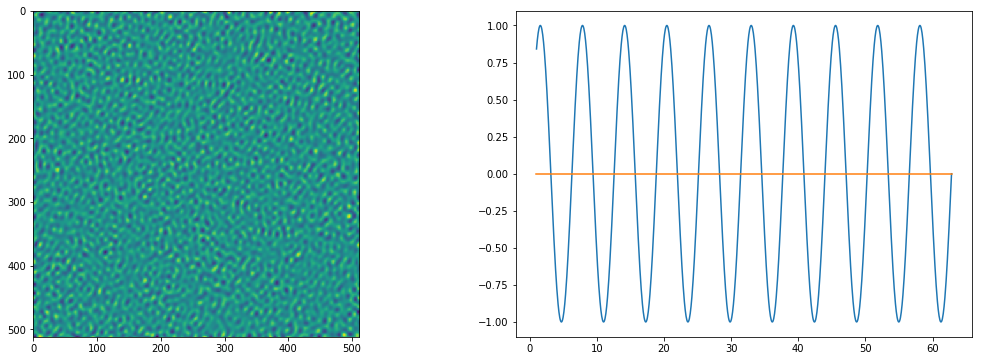

In [17]:
noise_image = "../data/fits/noise_image.fits"
with astropy.io.fits.open(noise_image) as hdu:
    data = hdu[0].data[0,0,...]

fig, (image, hist) = plt.subplots(1, 2, figsize=(18,6))
histogram, bins = np.histogram(data.flatten(), bins=401)

dmin = data.min()
dmax = data.max()
x = np.linspace(dmin, dmax, 401)
x=np.linspace(1,20*np.pi,1000)

im = image.imshow(data)

mean = data.mean()
sigma = data.std()
peak = histogram.max()

print(dmin,dmax,mean,sigma,peak)

gauss = lambda x, amp, mean, sigma: amp*np.exp( -(x-mean)**2/(2*sigma**2))
fitdata = gauss(x, peak, mean, sigma)
fitdata=np.sin(x)

plt.plot(x, fitdata)
plt.plot(x,x*0)
#plt.plot(x, histogram,'o')
#plt.yscale('log')
#plt.ylim(1)

实际上，噪声总是和天体辐射一起被测量到，同时，射电图像也会被各种仪器效应污染，在图像域里表现为伪辐射，所有这些因素使得我们很难对图像中的噪声进行描述。既然噪声在图像中往往占据着主导地位，因此任然可以用均值跟均方差对来噪声进行近似。接下来，我们在上面的噪声图像中加入几个源， 然后再来对噪声进行估计。

Now, in reality the noise has to measured in the presence of astrophysical emission. Furthermore, radio images are also contaminated by various instrumental effects which can manifest as spurious emission in the image domain. All these factors make it difficult to charercterize the noise in a synthesized image. Since the noise generally dominates the images, the mean and standard deviation of the entire image are still fairly good approximations of the noise. Let us now insert a few sources (image and flux distribution shown below) in the noise image from earlier and then try to estimate noise.

(1, 107211901.07343747)

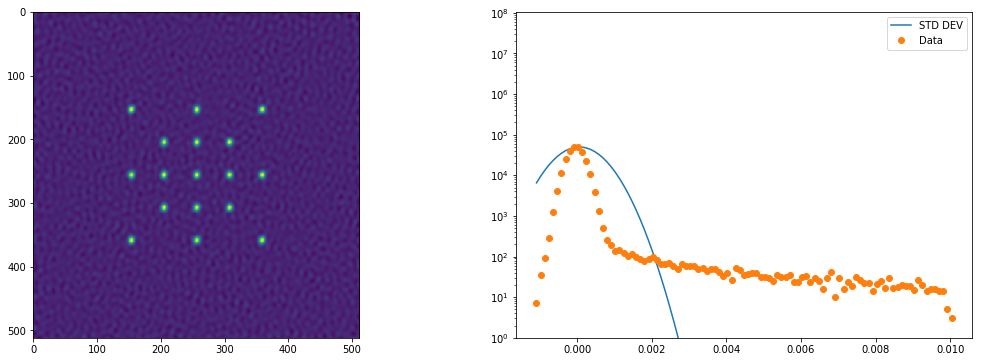

In [18]:
noise_image = "../data/fits/star_model_image.fits"
with astropy.io.fits.open(noise_image) as hdu:
    data = hdu[0].data[0,0,...]

fig, (image, hist) = plt.subplots(1, 2, figsize=(18,6))
histogram, bins = np.histogram(data.flatten(), bins=101)

dmin = data.min()
dmax = data.max()
x = np.linspace(dmin, dmax, 101)

im = image.imshow(data)

mean = data.mean()
sigma_std = data.std()

peak = histogram.max()

gauss = lambda x, amp, mean, sigma: amp*np.exp( -(x-mean)**2/(2*sigma**2))



fitdata_std = gauss(x, peak, mean, sigma_std)

plt.plot(x, fitdata_std, label="STD DEV")

plt.plot(x, histogram, "o", label="Data")
plt.legend(loc=1)

plt.yscale('log')
plt.ylim(1)

显然，图像中的像素统计不再呈高斯分布，因为右边多了一个长长的拖尾。依据均值跟标准差构建的高斯模型（右图中的蓝色）的拟合效果并不好，更好的方法是计算数据点相对均值或者中值的离散程度，即“均值/中值绝对偏差”（MAD）技术。我们把中值绝对偏差叫做“MAD Median”，均值绝对偏差叫做“MAD Mean”。假定所有的天体辐射（至少Stokes I）的流量密度都为正，在对综合孔径成像的噪声方差进行估计时只考虑正的像素值。下图显示了上述方法的噪声估计结果。

The pixel statistics of the image are no longer Gaussian as apparent from the long trail of the flux distribution. Constructing a Gaussian model from the mean and standard deviation results in a poor fit (blue line in the figure on the right). A better method to estimate the variance is to measure the dispersion of the data points about the mean (or median), this is the *mean/median absolute deviation* (MAD) technique. We will refer to the to median absolute deviation as the *MAD Median*, and the mean absolute deviation as the *MAD Mean*. A synthesis imaging specific method to estimate the variance of the noise is to only consider the negative pixels. This works under the assumption that all the astrophysical emission (at least in Stokes I) has a positive flux density. The Figure below shows noise estimates from methods mentioned above. 

(1, 3.109083029966627e+20)

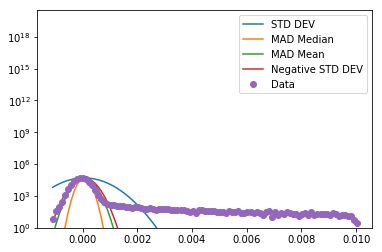

In [26]:
mean = data.mean()
sigma_std = data.std()
sigma_neg = data[data<0].std() * 2

mad_median = lambda a: np.median( abs(a - np.median(a) ))
sigma_mad_median = mad_median(data)

mad_mean = lambda a: np.mean( abs(a - np.mean(a) ))
sigma_mad_mean = mad_mean(data)

peak = histogram.max()

gauss = lambda x, amp, mean, sigma: amp*np.exp( -(x-mean)**2/(2*sigma**2))

fitdata_std = gauss(x, peak, mean, sigma_std)
fitdata_mad_median = gauss(x, peak, mean, sigma_mad_median)
fitdata_mad_mean = gauss(x, peak, mean, sigma_mad_mean)
fitdata_neg = gauss(x, peak, mean, sigma_neg)

plt.plot(x, fitdata_std, label="STD DEV")
plt.plot(x, fitdata_mad_median, label="MAD Median")
plt.plot(x, fitdata_mad_mean, label="MAD Mean")
plt.plot(x, fitdata_neg, label="Negative STD DEV")
plt.plot(x, histogram, "o", label="Data")
plt.legend(loc=1)

plt.yscale('log')
plt.ylim(1)

MAD和负值标准差更好地拟合了有源图的噪声分布。

The MAD and negtive value standard deviation methods produce a better solution to the noise distribution in the presence of sources.

### 6.5.2 Blob检测和特征化 Blob Detection and Charercterization

估计出噪声水平以后，下一步就是找出图像里的源，这在图像处理中被称为“blob检测”。在综合成像中，我们把一个blob简单定义为一组连续的像素，其空间亮度可以用一个2D高斯函数或者更复杂的函数来描述。一般地，我们喜欢把天空模型里的元素的相邻像素组合在一起，构成一个较为复杂的源。由于干涉测量阵列的空间分辨率有限，因此，我们可以进一步规定blob不能小于图像分辨率。基于上述理由，我们用“峰值peak”和“边界boundary”来定义blob。峰值定义为：

Once the noise has been estimated, the next step is to find and charecterize sources in the image. Generically in image processing this is known as *blob detection*. In a simple case during synthesis imaging we define a blob as a group contiguous pixels whose spatial intensity profile can be modelled by a 2D Gaussian function. Of course, more advanced functions could be used. Generally, we would like to group together near by pixels, such as spatially 'close' sky model components from deconvolution, into a single complex source. Our interferometric array has finite spatial resolution, so we can further constrain our blobs not to be significantly smaller than the image resolution. We define two further constraints of a blob, the *peak* and *boundary* thresholds. The peak threshold, defined as

$$ 
    \sigma_\text{peak} = n * \sigma,
$$

在一个blob里，最大的像素值必须大于这个峰值$\sigma_\text{peak}$。因此，所有不满足上述条件的blob将被排除在候选源之外。blob的边界定义为：

is the minimum intensity the maximum pixel in a blob must have relative to the image noise. That is, all blobs with peak pixel lower than $\sigma_\text{peak}$ will be excluded from being considered sources. And the boundary threshold

$$
    \sigma_\text{boundary} = m * \sigma,
$$

$m$ 和 $n$ 为自然数，其中$m$ < $n$。

defines the boundary of a blob, $m$ and $n$ are natural numbers with $m$ < $n$. 

#### 6.5.2.1 一个简单的源搜索器 A simple source finder

现在我们来写一个简单的源搜索器程序，主要包括下面几个步骤：

1、估计图像噪声，然后设置blob的峰值跟边界。
2、将低于边界值的像素设为零。
3、找出图像里的所有峰值。
4、针对每个峰值做2D高斯拟合，并从图像中减掉拟合出的高斯模型。
5、重复第4步，直到图像中没有高于域值的像素。

We are now in a position to write a simple source finder. To do so we implement the following steps: 

1. Estimate the image noise and set peak and boundary threshold values.
2. Blank out all pixel values below the boundary value.
3. Find Peaks in image.
4. For each peak, fit a 2D Gaussian and subtract the Gaussian fit from the image.
5. Repeat until the image has no pixels above the detection threshold.

In [48]:
def gauss2D(x, y, amp, mean_x, mean_y, sigma_x, sigma_y):
    """ Generate a 2D Gaussian image"""
    gx = -(x - mean_x)**2/(2*sigma_x**2)
    gy = -(y - mean_y)**2/(2*sigma_y**2)
    
    return amp * np.exp( gx + gy)

def err(p, xx, yy, data):
    """2D Gaussian error function"""
    return gauss2D(xx.flatten(), yy.flatten(), *p) - data.flatten()

def fit_gaussian(data, psf_pix):
    """Fit a gaussian to a 2D data set"""
    
    width = data.shape[0]
    mean_x, mean_y = width/2, width/2
    amp = data.max()
    sigma_x, sigma_y = psf_pix, psf_pix
    params0 = amp, mean_x, mean_y, sigma_x,sigma_y
        
    npix_x, npix_y = data.shape
    x = np.linspace(0, npix_x, npix_x)
    y = np.linspace(0, npix_y, npix_y)
    xx, yy = np.meshgrid(x, y)
        
        
    params, pcov, infoDict, errmsg, sucess = optimize.leastsq(err, 
                        params0, args=(xx.flatten(), yy.flatten(),
                        data.flatten()), full_output=1)
    
        
    perr = abs(np.diagonal(pcov))**0.5
    model = gauss2D(xx, yy, *params)


    return params, perr, model
 


In [32]:
def source_finder(data, peak, boundary, width, psf_pix):
    """A simple source finding tool"""
    
    # first we make an estimate of the noise. Lets use the MAD mean
    sigma_noise = mad_mean(data)

    # Use noise estimate to set peak and boundary thresholds
    peak_sigma = sigma_noise*peak
    boundary_sigma = sigma_noise*boundary
    
    # Pad the image to avoid hitting the edge of the image
    pad = width*2
    residual = np.pad(data, pad_width=((pad, pad), (pad, pad)), mode="constant")
    model = np.zeros(residual.shape)
    
    # Create slice to remove the padding later on
    imslice = [slice(pad, -pad), slice(pad,-pad)]
    
    catalog = [] 
    
    # We will need to convert the fitted sigma values to a width
    FWHM = 2*np.sqrt(2*np.log(2)) # 2.355 around
    
    while True:
        
        # Check if the brightest pixel is at least as bright as the sigma_peak
        # Otherwise stop.
        max_pix = residual.max()
        if max_pix<peak_sigma:
            break
        
        xpix, ypix = np.where(residual==max_pix)
        xpix = xpix[0] # Get first element
        ypix = ypix[0] # Get first element
        
        # Make slice that selects box of size width centred around bright brightest pixel
        subim_slice = [ slice(xpix-width//2, xpix+width//2),
                    slice(ypix-width//2, ypix+width//2) ]
        
        # apply slice to get subimage

        subimage = residual[subim_slice]
        
        
        # blank out pixels below the boundary threshold
        mask = subimage > boundary_sigma
        
        # Fit gaussian to submimage
        params, perr, _model = fit_gaussian(subimage*mask, psf_pix)
        
        amp, mean_x, mean_y, sigma_x,sigma_y = params
        amp_err, mean_x_err, mean_y_err, sigma_x_err, sigma_y_err = perr
        
        # Remember to reposition the source in original image
        pos_x = xpix + (width/2 - mean_x) - pad
        pos_y = ypix + (width/2 - mean_y) - pad
        
        # Convert sigma values to FWHM lengths
        size_x = FWHM*sigma_x
        size_y = FWHM*sigma_y
        
        # Add modelled source to model image
        model[subim_slice] = _model
        
        # create new source
        source = (
            amp,
            pos_x,
            pos_y,
            size_x,
            size_y
            )
                  
        # add source to catalogue
        catalog.append(source)
        
        # update residual image
        residual[subim_slice] -= _model       
        
    return catalog, model[imslice], residual[imslice], sigma_noise


利用设计好的这个源搜索器，从本节开始给出的测试图里搜索出了包括了所有17个源的天空模型。

Using this source finder we can produce a sky model which contains all 17 sources in our test image from earlier in the section.

Peak_Flux     Pix_x     Pix_y     Size_x     Size_y
  0.0103     153.5     255.8     7.85     9.80
  0.0102     204.4     255.6     7.88     9.81
  0.0102     306.7     204.4     8.02     9.59
  0.0102     255.8     204.5     7.90     9.88
  0.0101     204.3     306.8     8.30     9.48
  0.0100     255.0     357.4     8.30     9.47
  0.0100     255.5     255.5     8.18     9.56
  0.0102     153.0     153.0     8.09     9.60
  0.0101     153.1     357.9     8.46     9.41
  0.0101     357.9     153.2     8.07     9.70
  0.0100     357.3     357.1     8.26     9.76
  0.0099     255.3     306.5     8.27     9.60
  0.0098     306.6     255.4     8.43     9.60
  0.0098     306.2     306.3     8.33     9.51
  0.0097     357.4     255.2     8.83     9.62
  0.0097     204.7     204.7     8.26     10.02
  0.0096     255.9     153.5     8.46     9.73


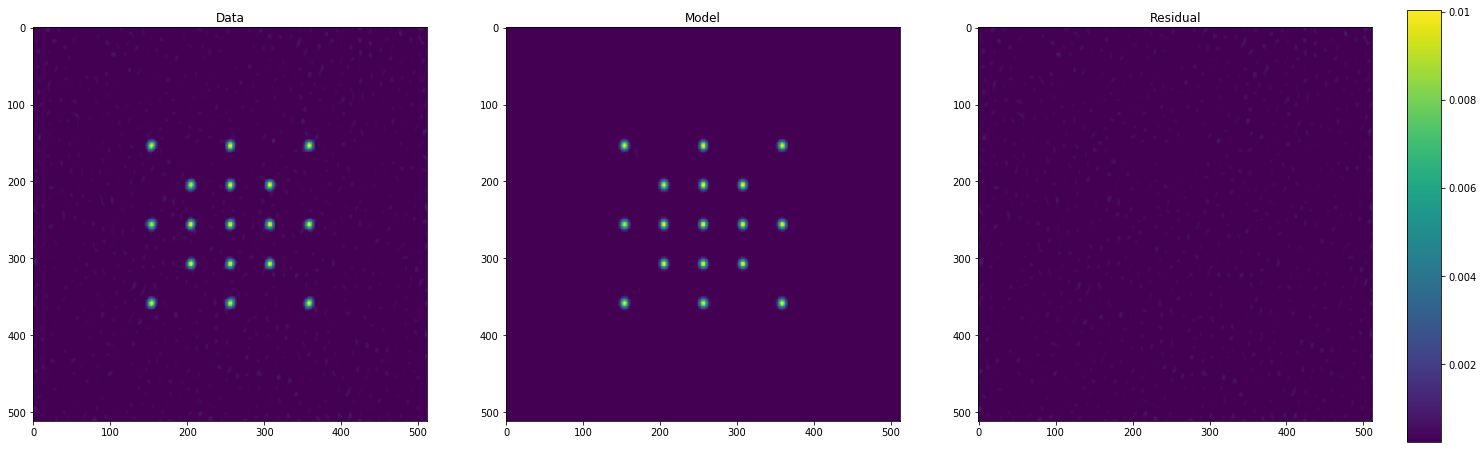

In [49]:
test_image = "../data/fits/star_model_image.fits"
with astropy.io.fits.open(test_image) as hdu:
    data = hdu[0].data[0,0,...]
    
catalog, model, residual, sigma_noise = source_finder(data, 5, 2, 50, 10)

print("Peak_Flux     Pix_x     Pix_y     Size_x     Size_y")
for source in catalog:
    print("  %.4f     %.1f     %.1f     %.2f     %.2f"%source)

fig, (img, mod, res) = plt.subplots(1, 3, figsize=(24,12))
vmin, vmax = sigma_noise, data.max()

im = img.imshow(data, vmin=vmin, vmax=vmax)
img.set_title("Data")

mod.imshow(model, vmin=vmin, vmax=vmax)
mod.set_title("Model")

res.imshow(residual, vmin=vmin, vmax=vmax)
res.set_title("Residual")

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax, format="%.2g")

由于图像里有噪声，所以搜出来的每个源的流量和位置跟真实的天空模型有点出入。上面的源搜索算法只起到一个抛砖引玉的作用，它有两个主要的缺陷：1）如果有几个源挨得很近，会被当成是一个源；2）因为射电图像中的噪声往往不均匀，所以需要引入局部噪声估计，设置不同的局部阈值。此外，针对特定类型的源，比如扩展源和谱线，需要使用更先进的源搜索器。

The flux and position on each source varies from the true sky model due to the image noise and distribution. The source finding algorithm we above is heuristic example. It has two major flaws : i) it is capable to handling a situation where two or more sources are close enough to each other that would fall within the same sub-image from which the source parameters are estimated, and ii) the noise in radio images is often non-uniform and 'local' noise estimates are required in order to set thresholds. More advanced source finders are used to work on specific source types such as extended objects and line spectra.

***

Next: [6.x Further Reading and References](6_x_further_reading_and_references.ipynb)

<div class=warn><b>Future Additions:</b></div>

* describe MAD and negative standard deviation methods
* figure titles and labels
* discussion on source finders commonly in use
* example: change the background noise or threshold values
* example: kat-7 standard image after deconvolution
* example: complex extended source
* example: location-dependent noise variations